<a href="https://colab.research.google.com/github/ChristianConchari/Computer-Vision-Notes/blob/master/Tutorial_16_Neural_Networks_for_Image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial 16: Neural Networks for Image Classification (Part 2)

The previous tutorial was meant to provide the basis of neural networks and PyTorch tensors. In this tutorial, we will continue with the definition, training, and validation of neural networks for image classification. The base notebook for this tutorial used [the MNIST dataset](https://en.wikipedia.org/wiki/MNIST_database), which is a well-known dataset to identify digits from grey-scale images of 28x28 pixels. Nevertheless, this dataset was created in 1998 and became trivial in recent years because usually deep learning and recent methods get a very-high accuracy in digit detection. 

Since MNIST is still important and only contains 10K instances, researchers at Facebook AI Research and NY university proposed an algorithm to generate new instances similar to MNIST in 2019. After many iterations of improvements in the reconstruction algorithm trying to extract the best matches between the generated and the original samples, researchers improved the samples and generated a dataset of an additional +50K digit images, which are available as [the QMNIST dataset](https://github.com/facebookresearch/qmnist). We will work with this dataset in this tutorial.


*Based on the material of the course 'Deep Learning with Pytorch' on Udacity*

## 1. Import libraries and the dataset. Display samples. 

In [ ]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

# PyTorch is a Python package that provides two high-level features:
# - Tensor computation (like NumPy) with strong GPU acceleration
# - Deep neural networks built on a tape-based autograd system
import torch

# The torchvision package consists of popular datasets, model architectures, and 
#common image transformations for computer vision.
from torchvision import datasets, transforms

In [ ]:
# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize(0.5, 0.5),
                             ])

# Download and load the training data
trainset = datasets.QMNIST('QMNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.QMNIST('QMNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

# Print details of the imported subsets
print("Trainset: ",trainset)
print("Testset: ",testset)

Trainset:  Dataset QMNIST
    Number of datapoints: 60000
    Root location: QMNIST_data/
    Split: train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=0.5, std=0.5)
           )
Testset:  Dataset QMNIST
    Number of datapoints: 60000
    Root location: QMNIST_data/
    Split: test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=0.5, std=0.5)
           )


Images' shape:  torch.Size([64, 1, 28, 28])
Labels' shape:  torch.Size([64])


Text(0.5, 1.0, '3')

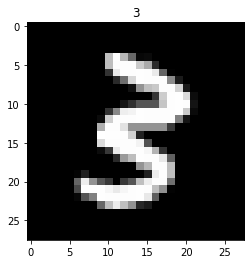

In [ ]:
# to get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

print("Images' shape: ", images.shape)
print("Labels' shape: ", labels.shape)

# Print the first image and label
plt.imshow(images[0].numpy().squeeze(), cmap='gray')
plt.title(labels[0].numpy())

## 2. Building neural networks with PyTorch

Here we'll use PyTorch to build a simple feedfoward network to classify the QMNIST images. That is, the network will receive a digit image as input and predict the digit in the image.

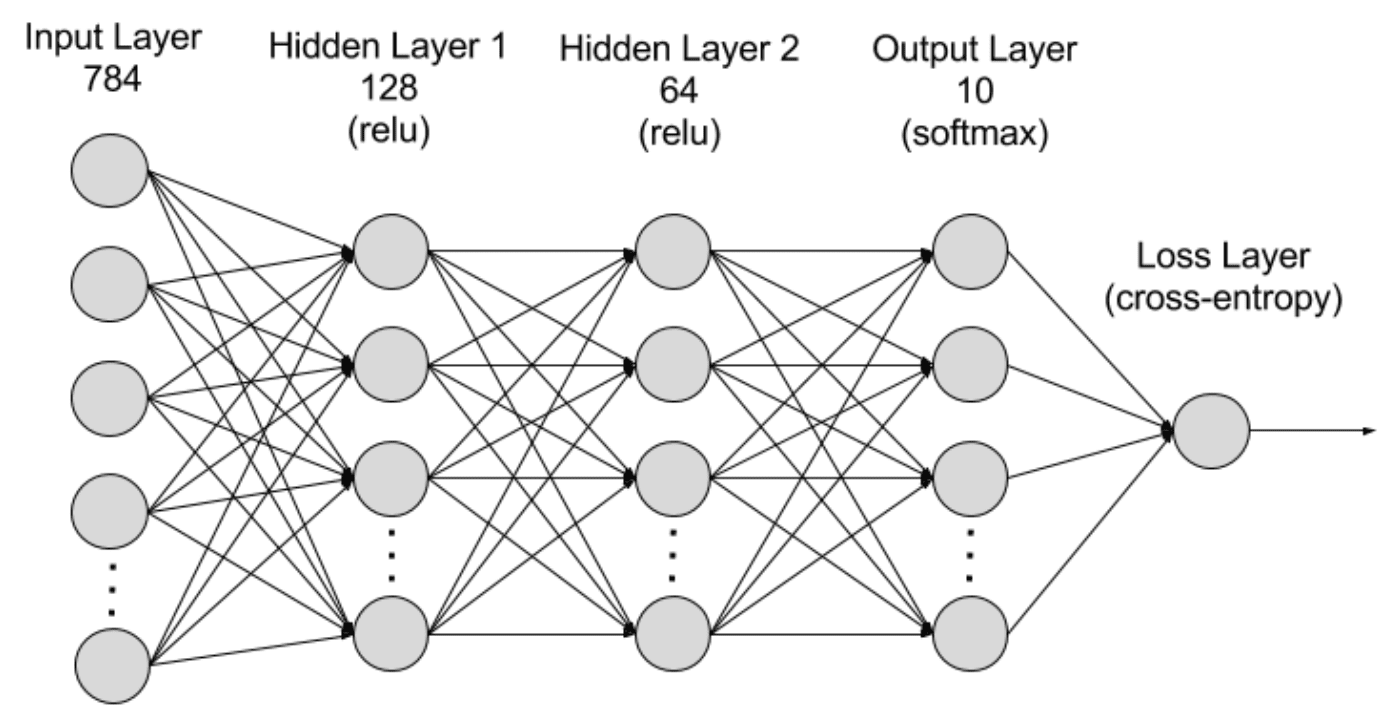

To build a neural network with PyTorch, you use the `torch.nn` module. The network itself is a class inheriting from `torch.nn.Module`. You define each of the operations separately, like `nn.Linear(784, 128)` for a fully connected linear layer with 784 inputs and 128 units.

The class needs to include a `forward` method that implements the forward pass through the network. In this method, you pass some input tensor `x` through each of the operations you defined earlier. The `torch.nn` module also has functional equivalents for things like ReLUs in `torch.nn.functional`. This module is usually imported as `F`. Then to use a ReLU activation on some layer (which is just a tensor), you'd do `F.relu(x)`. 

So, for this network, we'll build it with three fully connected layers, then a softmax output for predicting classes. The softmax function is similar to the sigmoid in that it squashes inputs between 0 and 1, but it's also normalized so that all the values sum to one like a proper probability distribution.

The weights and biases are automatically initialized.

In [ ]:
from torch import nn
from torch import optim
import torch.nn.functional as F

class Network(nn.Module):
    def __init__(self):
        super().__init__()
        # Defining the layers, 128, 64, 10 units each
        self.fc1 = nn.Linear(784, 128)
        self.fc2 = nn.Linear(128, 64)
        # Output layer, 10 units - one for each digit
        self.fc3 = nn.Linear(64, 10)
        
    def forward(self, x):
        ''' Forward pass through the network, returns the output logits '''
        
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.softmax(x, dim=1)
        
        return x

model = Network()
model

Network(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)

## 3. Training neural networks with PyTorch

So far, the defined neural network is dumb and requires training to be able of recognizing digits. We would like to get the following result: 

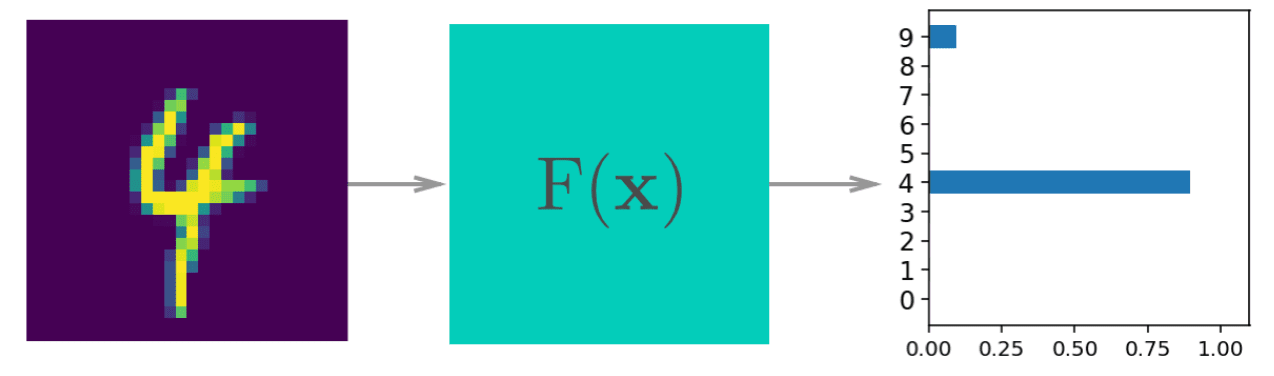

At first the network is naive, it doesn't know the function mapping the inputs to the outputs. We train the network by showing it examples of real data, then adjusting the network parameters such that it approximates this function.

To find these parameters, we need to know how poorly the network is predicting the real outputs. For this we calculate a loss function (also called the cost), a measure of our prediction error. For example, the mean squared loss is often used in regression and binary classification problems. 

$$
\ell = \frac{1}{2n}\sum_i^n{\left(y_i - \hat{y}_i\right)^2}
$$

where $n$ is the number of training examples, $y_i$ are the true labels, and $\hat{y}_i$ are the predicted labels.

By minimizing this loss with respect to the network parameters, we can find configurations where the loss is at a minimum and the network is able to predict the correct labels with high accuracy. We find this minimum using a process called **gradient descent**. The gradient is the slope of the loss function and points in the direction of fastest change. To get to the minimum in the least amount of time, we then want to follow the gradient (downwards). You can think of this like descending a mountain by following the steepest slope to the base.

For single layer networks, gradient descent is simple to implement. However, it's more complicated for deeper, multilayer neural networks like the one we've built. Complicated enough that it took about 30 years before researchers figured out how to train multilayer networks, although it's straightforward once you learn about it. 

This is done through **backpropagation** which is really just an application of the chain rule from calculus. It's easiest to understand if we convert a two layer network into a graph representation.

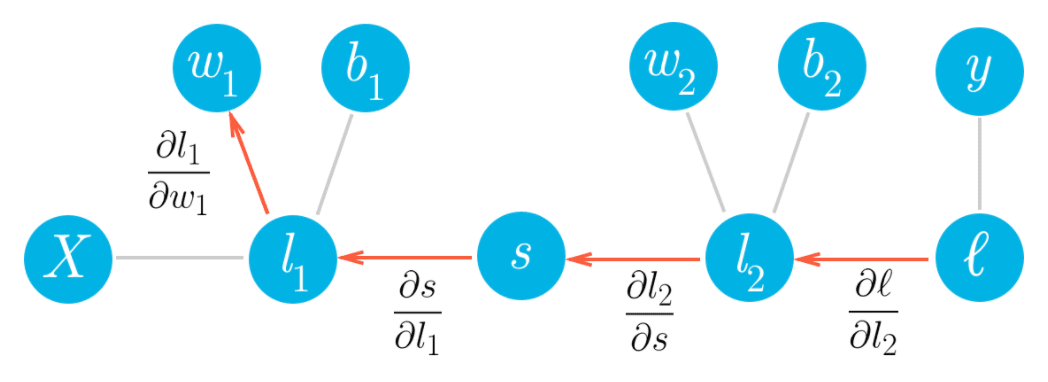

To train the weights with gradient descent, we propagate the gradient of the cost backwards through the network. Mathematically, this is really just calculating the gradient of the loss with respect to the weights using the chain rule.

$$
\frac{\partial \ell}{\partial w_1} = \frac{\partial l_1}{\partial w_1} \frac{\partial s}{\partial l_1} \frac{\partial l_2}{\partial s} \frac{\partial \ell}{\partial l_2}
$$

We update our weights using this gradient with some learning rate $\alpha$. 

$$
w^\prime = w - \alpha \frac{\partial \ell}{\partial w}
$$

The learning rate is set such that the weight update steps are small enough that the iterative method settles in a minimum.

### Autograd

Torch provides a module, `autograd`, for automatically calculating the gradient of tensors. It does this by keeping track of operations performed on tensors. To make sure PyTorch keeps track of operations on a tensor and calculates the gradients, you need to set `requires_grad` on a tensor. You can do this at creation with the `requires_grad` keyword, or at any time with `x.requires_grad_(True)`.

You can turn off gradients for a block of code with the `torch.no_grad()` content:
```python
x = torch.zeros(1, requires_grad=True)
>>> with torch.no_grad():
...     y = x * 2
>>> y.requires_grad
False
```

Also, you can turn on or off gradients altogether with `torch.set_grad_enabled(True|False)`.

The gradients are computed with respect to some variable `z` with `z.backward()`. This does a backward pass through the operations that created `z`.

In [ ]:
x = torch.randn(2,2, requires_grad=True)
print(x)

tensor([[-0.8364,  0.2944],
        [-1.3025,  0.7124]], requires_grad=True)


In [ ]:
y = x**2
print(y)

tensor([[0.6995, 0.0867],
        [1.6966, 0.5075]], grad_fn=<PowBackward0>)


Below we can see the operation that created `y`, a power operation `PowBackward0`.

In [ ]:
## grad_fn shows the function that generated this variable
print(y.grad_fn)

The autgrad module keeps track of these operations and knows how to calculate the gradient for each one. In this way, it's able to calculate the gradients for a chain of operations, with respect to any one tensor. Let's reduce the tensor `y` to a scalar value, the mean.

In [ ]:
z = y.mean()
print(z)

tensor(0.7476, grad_fn=<MeanBackward0>)


You can check the gradients for `x` and `y` but they are empty currently.

In [ ]:
print(x.grad)

None


To calculate the gradients, you need to run the `.backward` method on a Variable, `z` for example. This will calculate the gradient for `z` with respect to `x`

$$
\frac{\partial z}{\partial x} = \frac{\partial}{\partial x}\left[\frac{1}{n}\sum_i^n x_i^2\right] = \frac{x}{2}
$$

In [ ]:
z.backward()
print(x.grad)
print(x/2)

tensor([[-0.4182,  0.1472],
        [-0.6513,  0.3562]])
tensor([[-0.4182,  0.1472],
        [-0.6513,  0.3562]], grad_fn=<DivBackward0>)


These gradients calculations are particularly useful for neural networks. For training we need the gradients of the weights with respect to the cost. With PyTorch, we run data forward through the network to calculate the cost, then, go backwards to calculate the gradients with respect to the cost. Once we have the gradients we can make a gradient descent step. 

### Example of training

The first thing we need to do for training is define our loss function. In PyTorch, you'll usually see this as `criterion`. Here we're using softmax output, so we want to use `criterion = nn.CrossEntropyLoss()` as our loss. Later when training, you use `loss = criterion(output, targets)` to calculate the actual loss.

We also need to define the optimizer we're using, SGD or Adam, or something along those lines. Here I'll just use SGD with `torch.optim.SGD`, passing in the network parameters and the learning rate.

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

First, let's consider just one learning step before looping through all the data. The general process with PyTorch:

* Make a forward pass through the network to get the logits 
* Use the logits to calculate the loss
* Perform a backward pass through the network with `loss.backward()` to calculate the gradients
* Take a step with the optimizer to update the weights

Below we'll go through one training step and print out the weights and gradients so you can see how it changes.

In [ ]:
print('Initial weights - ', model.fc1.weight)

images, labels = next(iter(trainloader))
images.resize_(64, 784)

# Clear the gradients, do this because gradients are accumulated
optimizer.zero_grad()

# Forward pass, then backward pass, then update weights
output = model.forward(images)
loss = criterion(output, labels)
loss.backward()
print('Gradient -', model.fc1.weight.grad)
optimizer.step()

Initial weights -  Parameter containing:
tensor([[-0.0170,  0.0206, -0.0355,  ..., -0.0256, -0.0151,  0.0025],
        [-0.0078,  0.0280, -0.0036,  ...,  0.0332, -0.0284, -0.0307],
        [-0.0241, -0.0238, -0.0286,  ..., -0.0268,  0.0091,  0.0303],
        ...,
        [ 0.0340,  0.0195,  0.0002,  ..., -0.0049, -0.0173, -0.0280],
        [-0.0210, -0.0111, -0.0259,  ...,  0.0318,  0.0066, -0.0126],
        [ 0.0176,  0.0101,  0.0280,  ..., -0.0318,  0.0059, -0.0002]],
       requires_grad=True)
Gradient - tensor([[ 2.1346e-05,  2.1346e-05,  2.1346e-05,  ...,  2.1346e-05,
          2.1346e-05,  2.1346e-05],
        [ 1.1495e-04,  1.1495e-04,  1.1495e-04,  ...,  1.1495e-04,
          1.1495e-04,  1.1495e-04],
        [ 3.5007e-04,  3.5007e-04,  3.5007e-04,  ...,  3.5007e-04,
          3.5007e-04,  3.5007e-04],
        ...,
        [-1.3340e-04, -1.3340e-04, -1.3340e-04,  ..., -1.3340e-04,
         -1.3340e-04, -1.3340e-04],
        [-3.7635e-05, -3.7635e-05, -3.7635e-05,  ..., -3.7635e

In [ ]:
print('Updated weights - ', model.fc1.weight)

Updated weights -  Parameter containing:
tensor([[-0.0170,  0.0206, -0.0355,  ..., -0.0256, -0.0151,  0.0025],
        [-0.0078,  0.0280, -0.0036,  ...,  0.0332, -0.0284, -0.0307],
        [-0.0241, -0.0238, -0.0286,  ..., -0.0268,  0.0091,  0.0303],
        ...,
        [ 0.0340,  0.0195,  0.0002,  ..., -0.0049, -0.0173, -0.0280],
        [-0.0210, -0.0111, -0.0259,  ...,  0.0318,  0.0066, -0.0126],
        [ 0.0176,  0.0101,  0.0280,  ..., -0.0318,  0.0059, -0.0002]],
       requires_grad=True)


### Training for real

Now we'll put this algorithm into a loop so we can go through all the images. This is fairly straightforward. We'll loop through the mini-batches in our dataset, pass the data through the network to calculate the losses, get the gradients, then run the optimizer.

In [ ]:
optimizer = optim.SGD(model.parameters(), lr=0.003)

In [ ]:
epochs = 25
print_every = 500
steps = 0
for e in range(epochs):
    running_loss = 0
    for images, labels in iter(trainloader):
        steps += 1
        # Flatten QMNIST images into a 784 long vector
        images.resize_(images.size()[0], 784)
        
        optimizer.zero_grad()
        
        # Forward and backward passes
        output = model.forward(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        if steps % print_every == 0:
            print("Epoch: {}/{}... ".format(e+1, epochs),
                  "Loss: {:.4f}".format(running_loss/print_every))
            
            running_loss = 0

Epoch: 1/25...  Loss: 2.3010
Epoch: 2/25...  Loss: 0.2848
Epoch: 2/25...  Loss: 2.2942
Epoch: 3/25...  Loss: 0.5672
Epoch: 3/25...  Loss: 2.2812
Epoch: 4/25...  Loss: 0.8400
Epoch: 4/25...  Loss: 2.2394
Epoch: 5/25...  Loss: 1.0883
Epoch: 5/25...  Loss: 2.1611
Epoch: 6/25...  Loss: 1.3137
Epoch: 6/25...  Loss: 2.0991
Epoch: 7/25...  Loss: 1.5345
Epoch: 7/25...  Loss: 2.0450
Epoch: 8/25...  Loss: 1.7480
Epoch: 8/25...  Loss: 1.9874
Epoch: 9/25...  Loss: 1.9358
Epoch: 10/25...  Loss: 0.2208
Epoch: 10/25...  Loss: 1.8910
Epoch: 11/25...  Loss: 0.4474
Epoch: 11/25...  Loss: 1.8535
Epoch: 12/25...  Loss: 0.6720
Epoch: 12/25...  Loss: 1.8335
Epoch: 13/25...  Loss: 0.8842
Epoch: 13/25...  Loss: 1.7994
Epoch: 14/25...  Loss: 1.0855
Epoch: 14/25...  Loss: 1.7606
Epoch: 15/25...  Loss: 1.2840
Epoch: 15/25...  Loss: 1.7291
Epoch: 16/25...  Loss: 1.4814
Epoch: 16/25...  Loss: 1.7105
Epoch: 17/25...  Loss: 1.6770
Epoch: 18/25...  Loss: 0.1827
Epoch: 18/25...  Loss: 1.6970
Epoch: 19/25...  Loss: 0.3

With the network trained, we can check out it's predictions.

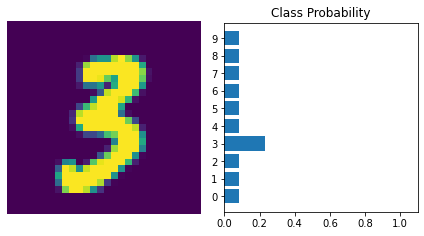

In [ ]:
images, labels = next(iter(trainloader))

img = images[0].view(1, 784)
# Turn off gradients to speed up this part
with torch.no_grad():
    logits = model.forward(img)

# Output of the network are logits, need to take softmax for probabilities
ps = F.softmax(logits, dim=1)

ps = ps.data.numpy().squeeze()

# Show the results
fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
ax1.axis('off')
ax2.barh(np.arange(10), ps)
ax2.set_aspect(0.1)
ax2.set_yticks(np.arange(10))

ax2.set_yticklabels(np.arange(10))

ax2.set_title('Class Probability')
ax2.set_xlim(0, 1.1)

plt.tight_layout()

Now our network is brilliant. It can accurately predict the digits in our images. Next up you'll write the code for training a neural network on a more complex dataset.

## 4. Inference and validation

Now that you have a trained network, you can use it for making predictions. This is typically called **inference**, a term borrowed from statistics. However, neural networks have a tendency to perform *too well* on the training data and aren't able to generalize to data that hasn't been seen before. This is called **overfitting** and it impairs inference performance. To test for overfitting while training, we measure the performance on data not in the training set called the **validation** dataset. We avoid overfitting through regularization such as dropout while monitoring the validation performance during training. 

Now that the model is trained, we can use it for inference. We've done this before, but now we need to remember to set the model in inference mode with `model.eval()`. You'll also want to turn off autograd with the `torch.no_grad()` context.

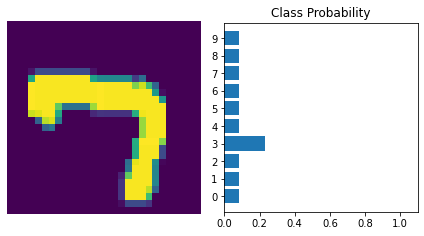

In [ ]:
# Test out your network!
model.eval()

dataiter = iter(testloader)
images, labels = dataiter.next()
img = images[0]
# Convert 2D image to 1D vector
img = img.view(1, 784)

# Pass an avaluation image
with torch.no_grad():
    output = model.forward(img)

# Output of the network are 10 logits, need to take softmax for probabilities
ps = F.softmax(logits, dim=1)

ps = ps.data.numpy().squeeze()

# Show the results
fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
ax1.axis('off')
ax2.barh(np.arange(10), ps)
ax2.set_aspect(0.1)
ax2.set_yticks(np.arange(10))

ax2.set_yticklabels(np.arange(10))

ax2.set_title('Class Probability')
ax2.set_xlim(0, 1.1)

plt.tight_layout()

# Exercise 1: Fashion MNIST

Now it's your turn to build and train a neural network. You'll be using the [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist). Fashion-MNIST is a set of 28x28 greyscale images of clothes. It's more complex than MNIST and QMNIST, so it's a better representation of the actual performance of your network, and a better representation of datasets you'll use in the real world.

In this notebook, you'll build your own neural network. For the most part, you could just copy and paste the code from the previous part, but you wouldn't be learning. It's important for you to write the code yourself and get it to work.

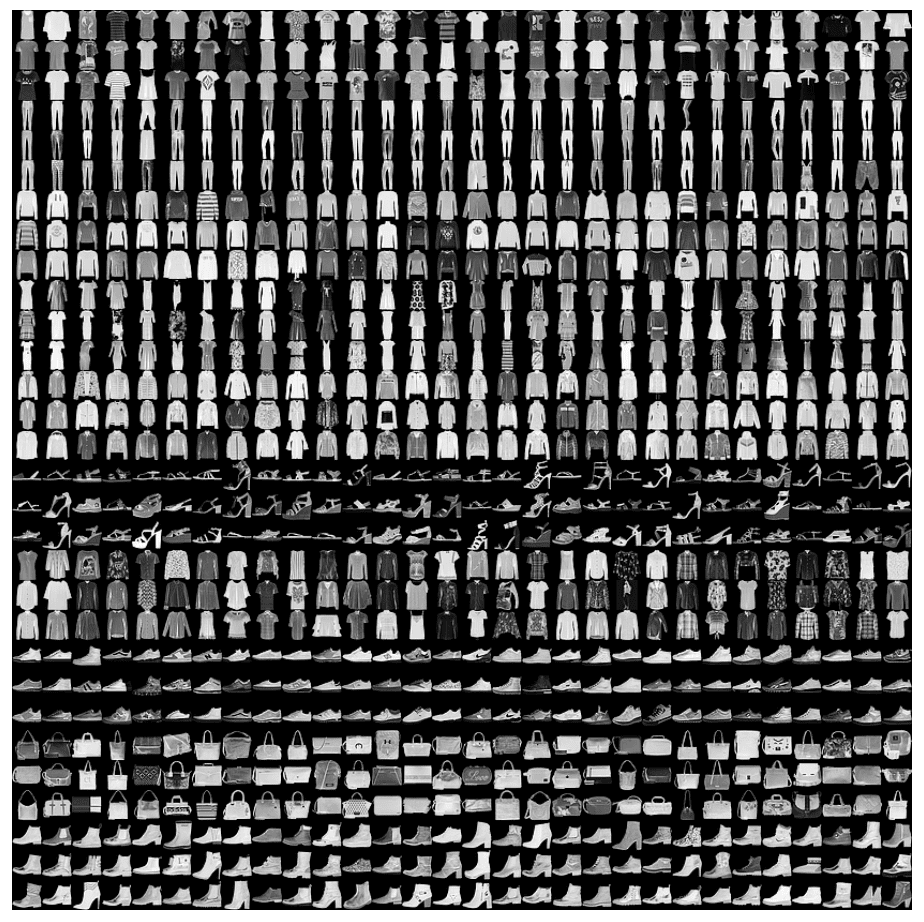

## 1. Import libraries and the dataset. Display samples. 

We will start by importing the necessary libraries for working with Pytorch

In [ ]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

# PyTorch is a Python package that provides two high-level features:
# - Tensor computation (like NumPy) with strong GPU acceleration
# - Deep neural networks built on a tape-based autograd system
import torch

# The torchvision package consists of popular datasets, model architectures, and 
#common image transformations for computer vision.
from torchvision import datasets, transforms

The next thing will be to import the training and validation datasets. The training dataset will be composed of 60 000 thousand elements. And the validation dataset will be composed of 10 000 thousand elements.

In [ ]:
# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize(0.5, 0.5),
                             ])

# Download and load the training data
trainset = datasets.FashionMNIST('data', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=10)

# Download and load the test data
testset = datasets.FashionMNIST('data', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True, num_workers=5)

# Define constant for classes - in this case we have 10 different articles of clothing
classes = {'T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'}
# Print details of the imported subsets
print("Trainset: ",trainset)
print("Testset: ",testset)

Trainset:  Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=0.5, std=0.5)
           )
Testset:  Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=0.5, std=0.5)
           )


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


To display an image that is part of the training dataset.

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Images' shape:  torch.Size([64, 1, 28, 28])
Labels' shape:  torch.Size([64])


Text(0.5, 1.0, '1')

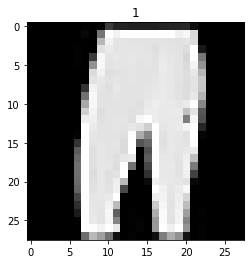

In [ ]:
# to get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

print("Images' shape: ", images.shape)
print("Labels' shape: ", labels.shape)

# Print the first image and label
plt.imshow(images[0].numpy().squeeze(), cmap='gray')
plt.title(labels[0].numpy())

## 2. Define the neuronal network architecture


For this network, we'll build it with four fully connected layers, then a 
logaritmic softmax output for predicting classes. This function is similar to the traditional softmax function, normalizing the outputs, so that all the values sum to one like a proper probability distribution.

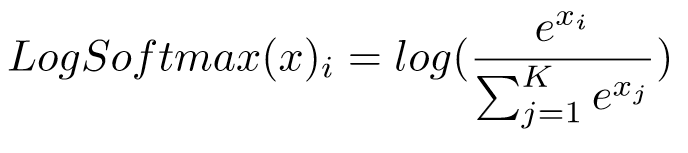

In the next cell the code is presented.

In [ ]:
from torch import nn
import torch.nn.functional as F

class Network(nn.Module):
    def __init__(self):
        super().__init__()
        # Defining the layers, 256, 128, 64, 10 units each
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        # Output layer, 10 units - one for each digit
        self.fc4 = nn.Linear(64, 10)
        
    def forward(self, x):
        # flat input tensor
        x = x.view(x.shape[0], -1)

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.log_softmax(self.fc4(x), dim=1)
        
        return x

model = Network()
model

Network(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=10, bias=True)
)

## 3. Define the loss function and optimizer

To define the loss function we are going to use the negative log likelihood loss (NLLLoss), a convex function. This function is very useful for training classification problems, and as we have seen in different forums it is usually used together with the softmax or in our case logarithmic softmax activation function.

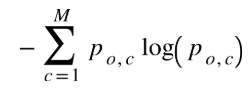

Also a stochastic gradient descent will be implemented. Note that use will also be made of the GPU provided by Google Colab via CUDA to accelerate data processing.

In [ ]:
from torch import optim

# move model to GPU
model.cuda()

# defining a metric for our loss function
criterion = nn.NLLLoss()

# selecting our optimizer, in this case the Adam Optimizer
optimizer = optim.SGD(model.parameters(), lr=0.01)

## 4. Training Loop

Let's make a calculation of the epochs, batches and size that'll be used in the following algorithm. 

If we use 25 epochs with a batch size of 500 with 60000 samples. Then 60000/500 = 120 batches will be used. each with 500 samples. This also means that one epoch will involve 120 batches or 120 updates to the model.

With 25 epochs,  the model will be exposed to or pass through the whole dataset 25 times. That is a total of 3000 batches during the entire training process.

At the moment the number of epochs used leads us to an optimum process.

In [ ]:
epochs = 25
print_every = 500
steps = 0
for e in range(epochs):
    running_loss = 0
    for images, labels in iter(trainloader):
        steps += 1
        # Flatten QMNIST images into a 784 long vector
        images.resize_(images.size()[0], 784)
        
        optimizer.zero_grad()
        
        # Forward and backward passes
        output = model(images.cuda())
        loss = criterion(output, labels.cuda())
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()

        if steps % print_every == 0:
            print("Epoch: {}/{}... ".format(e+1, epochs), "Loss: {:.4f}".format(running_loss/print_every))
        running_loss = 0

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch: 1/25...  Loss: 0.0013
Epoch: 2/25...  Loss: 0.0012
Epoch: 2/25...  Loss: 0.0012
Epoch: 3/25...  Loss: 0.0011
Epoch: 3/25...  Loss: 0.0009
Epoch: 4/25...  Loss: 0.0009
Epoch: 4/25...  Loss: 0.0013
Epoch: 5/25...  Loss: 0.0012
Epoch: 5/25...  Loss: 0.0009
Epoch: 6/25...  Loss: 0.0009
Epoch: 6/25...  Loss: 0.0009
Epoch: 7/25...  Loss: 0.0007
Epoch: 7/25...  Loss: 0.0008
Epoch: 8/25...  Loss: 0.0007
Epoch: 8/25...  Loss: 0.0006
Epoch: 9/25...  Loss: 0.0011
Epoch: 10/25...  Loss: 0.0008
Epoch: 10/25...  Loss: 0.0007
Epoch: 11/25...  Loss: 0.0005
Epoch: 11/25...  Loss: 0.0005
Epoch: 12/25...  Loss: 0.0008
Epoch: 12/25...  Loss: 0.0007
Epoch: 13/25...  Loss: 0.0006
Epoch: 13/25...  Loss: 0.0008
Epoch: 14/25...  Loss: 0.0010
Epoch: 14/25...  Loss: 0.0008
Epoch: 15/25...  Loss: 0.0008
Epoch: 15/25...  Loss: 0.0007
Epoch: 16/25...  Loss: 0.0009
Epoch: 16/25...  Loss: 0.0007
Epoch: 17/25...  Loss: 0.0005
Epoch: 18/25...  Loss: 0.0004
Epoch: 18/25...  Loss: 0.0004
Epoch: 19/25...  Loss: 0.0

As can be seen, the training was completed for 25 epochs and the results were quite good.

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


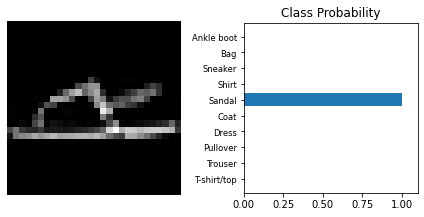

In [ ]:
images, labels = next(iter(trainloader))

img = images[0].view(1, 784)
# Turn off gradients to speed up this part
with torch.no_grad():
    logits = model(img.cuda())

# Output of the network are logits, need to take softmax for probabilities
ps = F.softmax(logits, dim=1).cpu()

ps = ps.data.numpy().squeeze()
# Show the results
fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze(),cmap='gray')
ax1.axis('off')
ax2.barh(np.arange(10), ps)
ax2.set_aspect(0.1)
ax2.set_yticks(np.arange(10))
ax2.set_yticklabels(['T-shirt/top',
                'Trouser',
                'Pullover',
                'Dress',
                'Coat',
                'Sandal',
                'Shirt',
                'Sneaker',
                'Bag',
                'Ankle boot'],size='small')

ax2.set_title('Class Probability')
ax2.set_xlim(0, 1.1)

plt.tight_layout()

For the training set, quite good results can be observed. 

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


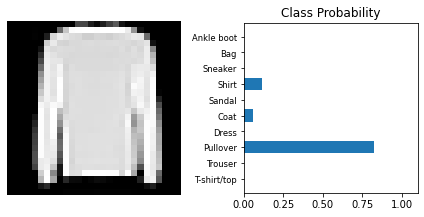

In [ ]:
# Test out your network!
model.eval()

images, labels = next(iter(testloader))

# Convert 2D image to 1D vector
img = images[56].view(1, 784)

# Pass an avaluation image
with torch.no_grad():
    logits = model(img.cuda())

# Output of the network are logits, need to take softmax for probabilities
ps = F.softmax(logits, dim=1).cpu()

ps = ps.data.numpy().squeeze()

# Show the results
fig2, (ax3, ax4) = plt.subplots(figsize=(6,9), ncols=2)
ax3.imshow(img.resize_(1, 28, 28).numpy().squeeze(), cmap='gray')
ax3.axis('off')
ax4.barh(np.arange(10), ps)
ax4.set_aspect(0.1)
ax4.set_yticks(np.arange(10))
ax4.set_yticklabels(['T-shirt/top',
                'Trouser',
                'Pullover',
                'Dress',
                'Coat',
                'Sandal',
                'Shirt',
                'Sneaker',
                'Bag',
                'Ankle boot'],size='small')

ax4.set_title('Class Probability')
ax4.set_xlim(0, 1.1)

plt.tight_layout()

Checking with the validation set, it can be seen that quite good classification results were also achieved.